# 내장된 방법을 통한 훈련 및 평가

## 설정

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 시작하기

이 안내서는 훈련 및 유효성 검증을 위해 내장 API를 사용할 때의 훈련, 평가 및 예측 (추론) 모델 (예 : `model.fit()` , `model.evaluate()` , `model.predict()` )에 대해 설명합니다.

고유한 훈련 단계 함수를 지정하면서 `fit()`을 사용하려면 <a href="https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/" data-md-type="link">" `fit()`에서 이루어지는 작업 사용자 정의하기"</a> 가이드를 참조하세요.

고유한 훈련 및 평가 루프를 처음부터 작성하려면 ["처음부터 훈련 루프 작성"](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/) 안내서를 참조하십시오.

일반적으로, 내장 루프를 사용하든 직접 작성하든 관계없이 모델 훈련 및 유효성 검사는 모든 종류의 Keras 모델(순차 모델, Functional API로 작성된 모델 및 모델 하위 클래스화를 통해 처음부터 작성된 모델)에서 완전히 동일하게 작동합니다.

이 가이드는 분산 교육에 대해서는 다루지 않습니다. 분산 교육에 대해서는 [멀티 GPU 및 분산 교육 안내서를](https://keras.io/guides/distributed_training/) 참조하십시오.

## API 개요 : 첫 번째 엔드 투 엔드 예제

데이터를 모델의 내장 훈련 루프로 전달할 때는 **NumPy 배열**(데이터가 작고 메모리에 맞는 경우) 또는 **`tf.data Dataset` 객체**를 사용해야 합니다. 다음 몇 단락에서는 옵티마이저, 손실 및 메트릭을 사용하는 방법을 보여주기 위해 MNIST 데이터세트를 NumPy 배열로 사용하겠습니다.

다음 모델을 고려해 보겠습니다 (여기서는 Functional API를 사용하여 빌드하지만 Sequential 모델 또는 하위 클래스 모델 일 수도 있음).

In [2]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

일반적인 엔드 투 엔드 워크 플로는 다음과 같이 구성되어 있습니다.

- 학습
- 원래 교육 데이터에서 생성 된 홀드 아웃 세트에 대한 유효성 검사
- 테스트 데이터에 대한 평가

이 예에서는 MNIST 데이터를 사용합니다.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

훈련 구성(최적화 프로그램, 손실, 메트릭)을 지정합니다.

In [4]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

`fit()`를 호출하여 데이터를 "batch_size" 크기의 "배치"로 분할하고 지정된 수의 "epoch"에 대해 전체 데이터세트를 반복 처리하여 모델을 훈련시킵니다.

In [5]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/2
782/782 [==============================] - 1s 1ms/step - loss: 0.3368 - sparse_categorical_accuracy: 0.9038 - val_loss: 0.1759 - val_sparse_categorical_accuracy: 0.9493
Epoch 2/2
782/782 [==============================] - 1s 844us/step - loss: 0.1538 - sparse_categorical_accuracy: 0.9549 - val_loss: 0.1339 - val_sparse_categorical_accuracy: 0.9620


반환되는 "이력" 객체는 훈련 중 손실 값과 메트릭 값에 대한 레코드를 유지합니다.

In [6]:
history.history

{'loss': [0.33681777119636536, 0.15375857055187225],
 'sparse_categorical_accuracy': [0.9038000106811523, 0.9549400210380554],
 'val_loss': [0.17589876055717468, 0.1339026540517807],
 'val_sparse_categorical_accuracy': [0.9492999911308289, 0.9620000123977661]}

`evaluate()`를 통해 테스트 데이터에 대해 모델을 평가합니다.

In [7]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)
print(predictions)

Evaluate on test data
79/79 [==============================] - 0s 601us/step - loss: 0.1382 - sparse_categorical_accuracy: 0.9570
test loss, test acc: [0.13823777437210083, 0.9570000171661377]
Generate predictions for 3 samples
predictions shape: (3, 10)
[[4.6720370e-06 4.6117172e-08 6.8958738e-04 7.9079304e-04 5.4314619e-09
  2.6632169e-06 2.9096109e-12 9.9848467e-01 4.4482572e-06 2.3011116e-05]
 [3.8985158e-06 2.0436446e-05 9.9993360e-01 4.0839794e-05 3.4088930e-11
  4.7482771e-07 9.5011011e-08 3.2027131e-07 2.9083216e-07 1.7645007e-11]
 [1.4071860e-05 9.9057454e-01 7.2112679e-04 3.7349857e-04 2.5732070e-04
  3.0762146e-04 7.0133807e-05 7.1805548e-03 3.0578344e-04 1.9533276e-04]]


이제이 워크 플로의 각 부분을 자세히 검토하겠습니다.

## `compile()` 메소드 : 손실, 메트릭 및 최적화 프로그램 지정

`fit()` 으로 모델을 학습하려면 손실 함수, 최적화 프로그램 및 선택적으로 모니터링 할 일부 메트릭을 지정해야합니다.

이것을 `compile()` 메소드의 인수로 모델에 전달합니다.

In [8]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

`metrics` 인수는 목록이어야합니다. 모델에는 여러 개의 메트릭이있을 수 있습니다.

모델에 여러 개의 출력이있는 경우 각 출력에 대해 서로 다른 손실 및 메트릭을 지정하고 모델의 총 손실에 대한 각 출력의 기여도를 조정할 수 있습니다. 이에 대한 자세한 내용은 **"다중 입력, 다중 출력 모델로 데이터 전달"** 섹션에서 확인할 수 있습니다.

기본 설정에 만족하면 대부분의 경우 최적화, 손실 및 메트릭을 문자열 식별자를 통해 바로 가기로 지정할 수 있습니다.

In [9]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

나중에 재사용하기 위해 모델 정의와 컴파일 단계를 함수에 넣겠습니다. 이 안내서의 여러 예에서 여러 번 호출합니다.

In [10]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model


### 많은 내장 옵티 마이저, 손실 및 메트릭을 사용할 수 있습니다

일반적으로 고유한 손실, 메트릭 또는 최적화 프로그램을 처음부터 새로 만들 필요가 없는데, Keras API에 필요한 것들이 이미 들어 있을 개연성이 높기 때문입니다.

옵티마이저

- `SGD()` (모멘텀이 있거나 없음)
- `RMSprop()`
- `Adam()`
- 기타

손실:

- `MeanSquaredError()`
- `KLDivergence()`
- `CosineSimilarity()`
- 기타

메트릭

- `AUC()`
- `Precision()`
- `Recall()`
- 기타

### 관례 손실

Keras로 커스텀 손실을 제공하는 두 가지 방법이 있습니다. 첫 번째 예는 입력 `y_true` 및 `y_pred` 를 받아들이는 함수를 만듭니다. 다음 예는 실제 데이터와 예측 간의 평균 제곱 오차를 계산하는 손실 함수를 보여줍니다.

In [11]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 1s 748us/step - loss: 0.0160


`y_true` 및 `y_pred` 이외의 매개 변수를 사용하는 손실 함수가 필요한 경우 `tf.keras.losses.Loss` 클래스를 서브 클래스 화하고 다음 두 메소드를 구현할 수 있습니다.

- `__init__(self)` : 손실 함수 호출 중에 전달할 매개 변수를 승인합니다.
- `call(self, y_true, y_pred)` : 목표 (y_true)와 모델 예측 (y_pred)을 사용하여 모델의 손실을 계산

평균 제곱 오차를 사용하려고하지만 예측 값을 0.5에서 멀어지게하는 용어가 추가되었다고 가정 해 보겠습니다 (우리는 범주 형 목표가 원-핫 인코딩되고 0과 1 사이의 값을 취하는 것으로 가정). 이렇게하면 모델이 너무 자신감이없는 인센티브가 생겨 과적 합을 줄이는 데 도움이 될 수 있습니다 (시도 할 때까지 작동하는지 알 수 없음).

방법은 다음과 같습니다.

In [12]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 1s 765us/step - loss: 0.0388


### 맞춤 측정 항목

API의 일부가 아닌 메트릭이 필요한 경우 `tf.keras.metrics.Metric` 클래스를 서브 클래 싱하여 사용자 지정 메트릭을 쉽게 만들 수 있습니다. 4 가지 방법을 구현해야합니다.

- `__init__(self)` . 여기서 메트릭에 대한 상태 변수를 만듭니다.
- `update_state(self, y_true, y_pred, sample_weight=None)` 대상 y_true 및 모델 예측 y_pred를 사용하여 상태 변수를 업데이트합니다.
- `result(self)` : 상태 변수를 사용하여 최종 결과를 계산합니다.
- `reset_states(self)` : 메트릭의 상태를 다시 초기화합니다.

경우에 따라 결과 계산이 매우 비싸고 주기적으로 만 수행되기 때문에 상태 업데이트와 결과 계산은 각각 `update_state()` 와 `result()` 에서 별도로 유지됩니다.

다음은 `CategoricalTruePositives` 메트릭을 구현하는 방법을 보여주는 간단한 예제입니다.이 메트릭은 주어진 클래스에 속하는 것으로 올바르게 분류 된 샘플 수를 계산합니다.

In [13]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
782/782 [==============================] - 1s 735us/step - loss: 0.3395 - categorical_true_positives: 45158.0000
Epoch 2/3
209/782 [=======>......................] - ETA: 0s - loss: 0.1705 - categorical_true_positives: 12733.0000

C:\Users\jikim\anaconda3\lib\site-packages\keras\engine\training.py:2034: UserWarning: Metric CategoricalTruePositives implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


782/782 [==============================] - 1s 721us/step - loss: 0.1617 - categorical_true_positives: 47631.0000
Epoch 3/3
782/782 [==============================] - 1s 736us/step - loss: 0.1189 - categorical_true_positives: 48255.0000


### 표준 서명에 맞지 않는 손실 및 메트릭 처리하기

거의 대부분의 손실과 메트릭은 `y_true` 및 `y_pred`에서 계산할 수 있습니다(여기서 `y_pred`가 모델의 출력). 그러나 모두가 그런 것은 아닙니다. 예를 들어, 정규화 손실은 레이어의 활성화만 요구할 수 있으며(이 경우 대상이 없음) 이 활성화는 모델 출력이 아닐 수 있습니다.

이러한 경우 사용자 정의 레이어의 호출 메서드 내에서 `self.add_loss(loss_value)`를 호출할 수 있습니다. 이러한 방식으로 추가된 손실은 훈련 중 "주요" 손실(`compile()`로 전달되는 손실)에 추가됩니다. 다음은 활동 정규화를 추가하는 간단한 예입니다. 참고로 활동 정규화는 모든 Keras 레이어에 내장되어 있으며 이 레이어는 구체적인 예를 제공하기 위한 것입니다.

In [14]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 1s 731us/step - loss: 2.5276


`add_metric()` 사용하여 메트릭 값 로깅에 대해 동일한 작업을 수행 할 수 있습니다.

In [15]:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 1s 728us/step - loss: 0.3409 - std_of_activation: 0.9768


[Functional API](https://www.tensorflow.org/guide/keras/functional/) 에서 `model.add_loss(loss_tensor)` 또는 `model.add_metric(metric_tensor, name, aggregation)` 호출 할 수도 있습니다.

다음은 간단한 예입니다.

In [16]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 1s 756us/step - loss: 2.5037 - std_of_activation: 0.0020


`add_loss()` 를 통해 손실을 전달하면 모델에는 이미 손실이 있으므로 손실 함수없이 `compile()` 을 호출 할 수 있습니다.

다음 `LogisticEndpoint` 레이어를 생각해 보겠습니다. 이 레이어는 입력으로 targets 및 logits를 받아들이고 `add_loss()`를 통해 교차 엔트로피 손실을 추적합니다. 또한 `add_metric()`를 통해 분류 정확도도 추적합니다.

In [17]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)


다음과 같이 `loss` 인수없이 컴파일 된 두 개의 입력 (입력 데이터 및 대상)이있는 모델에서 사용할 수 있습니다.

In [18]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - 0s 149ms/step - loss: 0.7884 - binary_accuracy: 0.0000e+00


다중 입력 모델 교육에 대한 자세한 내용은 **다중 입력, 다중 출력 모델로 데이터 전달** 섹션을 참조하십시오.

### 유효성 검사 홀드아웃 세트를 자동으로 분리하기

본 첫 번째 엔드 투 엔드 예제에서, 우리는 `validation_data` 인수를 사용하여 NumPy 배열의 튜플 `(x_val, y_val)` 을 모델에 전달하여 각 에포크의 끝에서 유효성 검증 손실 및 유효성 검증 메트릭을 평가합니다.

또 다른 옵션: 인수 `validation_split`를 사용하여 유효성 검사 목적으로 훈련 데이터의 일부를 자동으로 예약할 수 있습니다. 인수 값은 유효성 검사를 위해 예약할 데이터 비율을 나타내므로 0보다 크고 1보다 작은 값으로 설정해야 합니다. 예를 들어, `validation_split=0.2`는 "유효성 검사를 위해 데이터의 20%를 사용"한다는 의미이고`validation_split=0.6`은 "유효성 검사를 위해 데이터의 60%를 사용"한다는 의미입니다.

유효성을 계산하는 방법은 셔플 링 전에 맞춤 호출로 수신 한 배열의 마지막 x % 샘플을 가져 오는 것입니다.

NumPy 데이터를 학습 할 때 `validation_split` 만 사용할 수 있습니다.

In [19]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

625/625 [==============================] - 1s 957us/step - loss: 0.3608 - sparse_categorical_accuracy: 0.8992 - val_loss: 0.2319 - val_sparse_categorical_accuracy: 0.9309


## tf.data 데이터 세트의 교육 및 평가

앞서 몇 단락에 걸쳐 손실, 메트릭 및 옵티마이저를 처리하는 방법을 살펴보았으며, 데이터가 NumPy 배열로 전달될 때 fit에서 `validation_data` 및 `validation_split` 인수를 사용하는 방법도 알아보았습니다.

이제 데이터가 `tf.data.Dataset` 객체의 형태로 제공되는 경우를 살펴 보겠습니다.

`tf.data` API는 빠르고 확장 가능한 방식으로 데이터를 로드하고 사전 처리하기 위한 TensorFlow 2.0의 유틸리티 세트입니다.

`Datasets` 생성에 대한 자세한 설명은 [tf.data 설명서](https://www.tensorflow.org/guide/data)를 참조하세요.

`Dataset` 인스턴스를 메서드 `fit()`, `evaluate()` 및 `predict()`로 직접 전달할 수 있습니다.

In [20]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3
782/782 [==============================] - 1s 883us/step - loss: 0.3340 - sparse_categorical_accuracy: 0.9046
Epoch 2/3
782/782 [==============================] - 1s 888us/step - loss: 0.1587 - sparse_categorical_accuracy: 0.9529
Epoch 3/3
782/782 [==============================] - 1s 891us/step - loss: 0.1177 - sparse_categorical_accuracy: 0.9645
Evaluate
157/157 [==============================] - 0s 664us/step - loss: 0.1134 - sparse_categorical_accuracy: 0.9664


{'loss': 0.1133546233177185, 'sparse_categorical_accuracy': 0.9664000272750854}

데이터세트는 각 epoch의 끝에서 재설정되므로 다음 epoch에서 재사용할 수 있습니다.

이 데이터세트의 특정 배치 수에 대해서만 훈련을 실행하려면 다음 epoch로 이동하기 전에 이 데이터세트를 사용하여 모델이 실행해야 하는 훈련 단계의 수를 지정하는 `steps_per_epoch` 인수를 전달할 수 있습니다.

이렇게 하면 각 epoch가 끝날 때 데이터세트가 재설정되지 않고 다음 배치를 계속 가져오게 됩니다. 무한 반복되는 데이터세트가 아니라면 결국 데이터세트의 데이터가 고갈됩니다.

In [21]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3
100/100 [==============================] - 0s 907us/step - loss: 0.7843 - sparse_categorical_accuracy: 0.7987
Epoch 2/3
100/100 [==============================] - 0s 878us/step - loss: 0.3726 - sparse_categorical_accuracy: 0.8938
Epoch 3/3
100/100 [==============================] - 0s 858us/step - loss: 0.3285 - sparse_categorical_accuracy: 0.9081


### 유효성 검사 데이터 집합 사용

`fit()` 에서 `Dataset` 인스턴스를 `validation_data` 인수로 전달할 수 있습니다.

In [22]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

782/782 [==============================] - 1s 1ms/step - loss: 0.3365 - sparse_categorical_accuracy: 0.9055 - val_loss: 0.1798 - val_sparse_categorical_accuracy: 0.9474


각 시대가 끝날 때 모델은 유효성 검사 데이터 집합을 반복하고 유효성 검사 손실 및 유효성 검사 메트릭을 계산합니다.

이 데이터세트의 특정 배치 수에 대해서만 유효성 검사를 실행하려면 유효성 검사를 중단하고 다음 epoch로 넘어가기 전에 유효성 검사 데이터세트에서 모델이 실행해야 하는 유효성 검사 단계의 수를 지정하는 `validation_steps` 인수를 전달할 수 있습니다.

In [23]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

782/782 [==============================] - 1s 954us/step - loss: 0.3297 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.3112 - val_sparse_categorical_accuracy: 0.9297


유효성 검사 데이터 세트는 사용 후마다 재설정되므로 항상 에포크에서 에포크까지 동일한 샘플을 평가하게됩니다.

인수 `validation_split`(훈련 데이터로부터 홀드아웃 세트 생성)는 `Dataset` 객체로 훈련할 때는 지원되지 않는데, 이를 위해서는 데이터세트 샘플을 인덱싱할 수 있어야 하지만 `Dataset` API에서는 일반적으로 이것이 불가능하기 때문입니다.

## 지원되는 다른 입력 형식

NumPy 배열, 즉시 실행 텐서 및 TensorFlow `Datasets` 외에도 Pandas 데이터프레임을 사용하거나 데이터 및 레이블의 배치를 생성하는 Python 생성기에서 Keras 모델을 훈련할 수 있습니다.

특히, `keras.utils.Sequence` 클래스는 멀티스레딩을 인식하고 셔플이 가능한 Python 데이터 생성기를 빌드하기 위한 간단한 인터페이스를 제공합니다.

일반적으로 다음을 사용하는 것이 좋습니다.

- 데이터가 작고 메모리에 맞는 경우 NumPy 입력 데이터
- 큰 데이터세트가 있고 분산 훈련을 수행해야 하는 경우 `Dataset` 객체
- 큰 데이터세트가 있고 TensorFlow에서 수행할 수 없는 많은 사용자 정의 Python 측 처리를 수행해야 하는 경우(예: 데이터 로드 또는 사전 처리를 위해 외부 라이브러리에 의존하는 경우) `Sequence` 객체

## `keras.utils.Sequence` 객체를 입력으로 사용하기

`keras.utils.Sequence`는 두 가지 중요한 속성을 가진 Python 생성기를 얻기 위해 하위 클래스화를 수행할 수 있는 유틸리티입니다.

- 멀티 프로세싱과 잘 작동합니다.
- 셔플할 수 있습니다(예: `fit()`에서 `shuffle=True`를 전달하는 경우).

`Sequence` 는 두 가지 방법을 구현해야합니다.

- `__getitem__`
- `__len__`

`__getitem__` 메소드는 완전한 배치를 리턴해야합니다. 신기원 사이의 데이터 세트를 수정하려면 `on_epoch_end` 구현할 수 있습니다.

간단한 예를 들자면 다음과 같습니다.

```python
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)
```

## 샘플 가중치 및 클래스 가중치 사용

기본 설정을 사용하면 샘플의 무게가 데이터 세트의 빈도에 따라 결정됩니다. 샘플 빈도와 관계없이 데이터에 가중치를 부여하는 방법에는 두 가지가 있습니다.

- 클래스 가중치
- 샘플 무게

### 클래스 가중치

이 가중치는 `Model.fit()`에 대한 `class_weight` 인수로 사전을 전달하여 설정합니다. 이 사전은 클래스 인덱스를 이 클래스에 속한 샘플에 사용해야 하는 가중치에 매핑합니다.

이 방법은 샘플링을 다시 수행하지 않고 클래스의 균형을 맞추거나 특정 클래스에 더 중요한 모델을 훈련시키는 데 사용할 수 있습니다.

예를 들어, 데이터에서 클래스 "0"이 클래스 "1"로 표시된 것의 절반인 경우 `Model.fit(..., class_weight={0: 1., 1: 0.5})`을 사용할 수 있습니다.

다음은 클래스 #5(MNIST 데이터세트에서 숫자 "5")의 올바른 분류에 더 많은 중요성을 두도록 클래스 가중치 또는 샘플 가중치를 사용하는 NumPy 예입니다.

In [24]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight
782/782 [==============================] - 1s 788us/step - loss: 0.3717 - sparse_categorical_accuracy: 0.9020


### 샘플 무게

세밀한 제어를 위해 또는 분류기를 작성하지 않는 경우 "샘플 가중치"를 사용할 수 있습니다.

- NumPy 데이터에서 학습하는 경우 : `sample_weight` 인수를 `Model.fit()` .
- `tf.data` 또는 다른 종류의 반복자에서 훈련 할 때 : Yield `(input_batch, label_batch, sample_weight_batch)` 튜플.

"샘플 가중치"배열은 배치에서 각 샘플이 총 손실을 계산하는 데 필요한 가중치를 지정하는 숫자 배열입니다. 불균형 분류 문제 (거의 보이지 않는 클래스에 더 많은 가중치를 부여하는 아이디어)에 일반적으로 사용됩니다.

사용 된 가중치가 1과 0 인 경우, 어레이는 손실 함수에 대한 *마스크* 로 사용될 수 있습니다 (전체 손실에 대한 특정 샘플의 기여를 완전히 버림).

In [25]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight
782/782 [==============================] - 1s 782us/step - loss: 0.3824 - sparse_categorical_accuracy: 0.8988


일치하는 `Dataset` 예는 다음과 같습니다.

In [26]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 1s 942us/step - loss: 0.3716 - sparse_categorical_accuracy: 0.9038


## 다중 입력, 다중 출력 모델로 데이터 전달

이전 예에서는 단일 입력(형상 `(764,)`의 텐서)과 단일 출력(형상 `(10,)`의 예측 텐서)이 있는 모델을 고려했습니다. 그렇다면 입력 또는 출력이 여러 개인 모델은 어떨까요?

shape `(32, 32, 3)` ( `(height, width, channels)` 입력과 shape `(None, 10)` 의 시계열 입력 `(timesteps, features)` 하십시오. 우리의 모델은이 입력들의 조합으로부터 계산 된 두 개의 출력을 가질 것입니다 : "점수"(모양 `(1,)` )와 5 개의 클래스 (모양 `(5,)` )에 대한 확률 분포.

In [27]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

이 모델을 플로팅하여 여기서 수행중인 작업을 명확하게 확인할 수 있습니다 (플롯에 표시된 셰이프는 샘플 별 셰이프가 아니라 배치 셰이프 임).

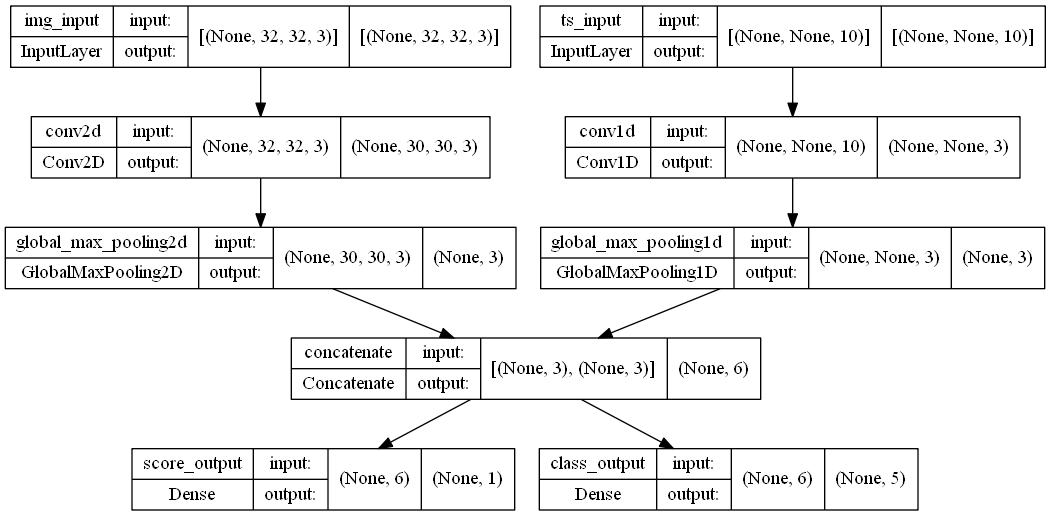

In [28]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

컴파일 타임에 손실 함수를 목록으로 전달하여 출력마다 다른 손실을 지정할 수 있습니다.

In [29]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

모델에 단일 손실 함수만 전달하는 경우, 모든 출력에 동일한 손실 함수가 적용됩니다(여기서는 적합하지 않음).

메트릭의 경우도 마찬가지입니다.

In [30]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

출력 레이어에 이름을 지정 했으므로 dict를 통해 출력 당 손실 및 메트릭을 지정할 수도 있습니다.

In [31]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

출력이 두 개 이상인 경우 명시적 이름과 사전을 사용하는 것이 좋습니다.

`loss_weights` 인수를 사용하여 출력별 손실에 서로 다른 가중치를 부여할 수 있습니다(예를 들어, 클래스 손실에 2x의 중요도를 부여하여 이 예에서 "score" 손실에 우선권을 줄 수 있음).

In [32]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

이러한 출력이 예측 용이지만 훈련 용이 아닌 경우 특정 출력에 대한 손실을 계산하지 않도록 선택할 수도 있습니다.

In [33]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

적합하게 다중 입력 또는 다중 출력 모델에 데이터를 전달하는 것은 컴파일에서 손실 함수를 지정하는 것과 유사한 방식으로 작동합니다. **NumPy 배열 목록을** 전달할 수 있습니다 (손실 함수를 수신 한 출력에 1 : 1 매핑). **출력 이름을 NumPy 배열에 매핑합니다** .

In [35]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
# model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

4/4 [==============================] - 0s 3ms/step - loss: 12.0658 - score_output_loss: 1.0065 - class_output_loss: 11.0593


`Dataset` 사용 사례는 다음과 같습니다. NumPy 배열에서 수행 한 것과 유사하게 `Dataset` 은 튜플 튜플을 반환해야합니다.

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

2/2 [==============================] - 0s 5ms/step - loss: 10.9422 - score_output_loss: 0.7318 - class_output_loss: 10.2104


## 콜백 사용하기

Keras의 콜백은 훈련 중 다른 시점(epoch의 시작, 배치의 끝, epoch의 끝 등)에서 호출되며 다음과 같은 동작을 구현하는 데 사용할 수 있는 객체입니다.

- 훈련 중 서로 다른 시점에서 유효성 검사 수행(내장된 epoch당 유효성 검사에서 더욱 확장)
- 정기적으로 또는 특정 정확도 임계값을 초과할 때 모델 검사점 설정
- 훈련이 정체 된 것처럼 보일 때 모델의 학습 속도 변경
- 훈련이 정체 된 것처럼 보일 때 최상위 레이어의 미세 조정
- 교육이 종료되거나 특정 성능 임계 값을 초과 한 경우 전자 메일 또는 인스턴트 메시지 알림 보내기
- 기타

콜백은 `fit()` 에 대한 호출에 목록으로 전달 될 수 있습니다.

In [37]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3798 - sparse_categorical_accuracy: 0.8921 - val_loss: 0.2200 - val_sparse_categorical_accuracy: 0.9317
Epoch 2/20
625/625 [==============================] - 1s 886us/step - loss: 0.1703 - sparse_categorical_accuracy: 0.9497 - val_loss: 0.1806 - val_sparse_categorical_accuracy: 0.9465
Epoch 3/20
625/625 [==============================] - 1s 895us/step - loss: 0.1234 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.1474 - val_sparse_categorical_accuracy: 0.9580
Epoch 4/20
625/625 [==============================] - 1s 914us/step - loss: 0.0971 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.1332 - val_sparse_categorical_accuracy: 0.9608
Epoch 5/20
625/625 [==============================] - 1s 886us/step - loss: 0.0789 - sparse_categorical_accuracy: 0.9766 - val_loss: 0.1325 - val_sparse_categorical_accuracy: 0.9614
Epoch 6/20
625/625 [==============================] - 1s 872us/step - loss: 0.0652 - sparse_

### 많은 내장 콜백을 사용할 수 있습니다

- `ModelCheckpoint` : 주기적으로 모델을 저장합니다.
- `EarlyStopping`: 훈련이 더 이상 유효성 검사 메트릭을 개선하지 못하는 경우 훈련을 중단합니다.
- `TensorBoard` : 시각화 할 수 있습니다 정기적으로 쓰기 모델 로그 [TensorBoard](https://www.tensorflow.org/tensorboard) (섹션 "시각화"에서 자세한 내용).
- `CSVLogger` : 손실 및 메트릭 데이터를 CSV 파일로 스트리밍합니다.
- 기타

전체 목록은 [콜백 설명서](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/) 를 참조하십시오.

### 자신의 콜백 작성

기본 클래스 `keras.callbacks.Callback` 을 확장하여 사용자 정의 콜백을 작성할 수 있습니다. 콜백은 클래스 속성 `self.model` 통해 연관된 모델에 액세스 할 수 있습니다.

[사용자 정의 콜백을 작성하기 위한 전체 가이드](https://www.tensorflow.org/guide/keras/custom_callback/)를 꼭 읽어보세요. 다음은 훈련 중 배치별 손실 값 목록을 저장하는 간단한 예입니다.

다음은 훈련 중 배치 별 손실 값 목록을 저장하는 간단한 예입니다.

In [38]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))


## 모델 검사점 설정하기

상대적으로 큰 데이터세트에 대한 모델을 훈련시킬 때는 모델의 검사점을 빈번하게 저장하는 것이 중요합니다.

이를 수행하는 가장 쉬운 방법은 `ModelCheckpoint` 콜백을 사용하는 것입니다.

In [39]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2
609/625 [============================>.] - ETA: 0s - loss: 0.3797 - sparse_categorical_accuracy: 0.8929
Epoch 1: val_loss improved from inf to 0.23066, saving model to mymodel_1
INFO:tensorflow:Assets written to: mymodel_1\assets
625/625 [==============================] - 1s 2ms/step - loss: 0.3762 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.2307 - val_sparse_categorical_accuracy: 0.9305
Epoch 2/2
614/625 [============================>.] - ETA: 0s - loss: 0.1743 - sparse_categorical_accuracy: 0.9477
Epoch 2: val_loss improved from 0.23066 to 0.17412, saving model to mymodel_2
INFO:tensorflow:Assets written to: mymodel_2\assets
625/625 [==============================] - 1s 1ms/step - loss: 0.1749 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.1741 - val_sparse_categorical_accuracy: 0.9477


`ModelCheckpoint` 콜백을 사용하여 내결함성을 구현할 수 있습니다. 훈련이 무작위로 중단 된 경우 모델의 마지막 저장된 상태에서 훈련을 다시 시작할 수있는 기능. 기본 예는 다음과 같습니다.

In [40]:
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Restoring from ./ckpt/ckpt-loss=0.32
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.9554


또한 모델 저장 및 복원을 위해 자체 콜백을 작성하십시오.

직렬화 및 저장에 대한 전체 안내서는 [모델 저장 및 직렬화 안내서를](https://www.tensorflow.org/guide/keras/save_and_serialize/) 참조하십시오.

## 학습 속도 일정 사용하기

딥 러닝 모델을 훈련 할 때 일반적인 패턴은 훈련이 진행됨에 따라 점차적으로 학습을 줄이는 것입니다. 이것을 일반적으로 "학습률 감소"라고합니다.

학습 붕괴 스케줄은 정적 인 (현재 에포크 또는 현재 배치 인덱스의 함수로서 미리 고정됨) 또는 동적 (모델의 현재 행동, 특히 검증 손실에 대응) 일 수있다.

### 옵티마이저로 일정 전달하기

옵티 마이저에서 schedule 객체를 `learning_rate` 인수로 전달하여 정적 학습 속도 감소 스케줄을 쉽게 사용할 수 있습니다.

In [41]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

`ExponentialDecay` , `PiecewiseConstantDecay` , `PolynomialDecay` 및 `InverseTimeDecay` 와 같은 몇 가지 기본 제공 일정을 사용할 수 있습니다.

### 콜백을 사용하여 동적 학습 속도 일정 구현

옵티마이저가 유효성 검사 메트릭에 액세스할 수 없으므로 이러한 일정 객체로는 동적 학습률 일정(예: 유효성 검사 손실이 더 이상 개선되지 않을 때 학습률 감소)을 달성할 수 없습니다.

그러나 콜백은 유효성 검사 메트릭을 포함해 모든 메트릭에 액세스할 수 있습니다! 따라서 옵티마이저에서 현재 학습률을 수정하는 콜백을 사용하여 이 패턴을 달성할 수 있습니다. 실제로 이 부분이`ReduceLROnPlateau` 콜백으로 내장되어 있습니다.

## 훈련 중 손실 및 메트릭 시각화하기

교육 중에 모델을 주시하는 가장 좋은 방법은 로컬에서 실행할 수있는 브라우저 기반 응용 프로그램 인 [TensorBoard](https://www.tensorflow.org/tensorboard) 를 사용하는 것입니다.

- 교육 및 평가를위한 손실 및 지표의 라이브 플롯
- (옵션) 레이어 활성화 히스토그램 시각화
- (옵션) `Embedding` 레이어에서 학습한 포함된 공간의 3D 시각화

pip와 함께 TensorFlow를 설치한 경우, 명령줄에서 TensorBoard를 시작할 수 있습니다.

```
tensorboard --logdir=/full_path_to_your_logs
```

### TensorBoard 콜백 사용하기

TensorBoard를 Keras 모델 및 fit 메서드와 함께 사용하는 가장 쉬운 방법은 `TensorBoard` 콜백입니다.

가장 간단한 경우로, 콜백에서 로그를 작성할 위치만 지정하면 바로 쓸 수 있습니다.

In [ ]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

자세한 내용 [`TensorBoard` 콜백 설명서](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/tensorboard/)를 참조하세요.